# Projection code for m48

In [1]:
#Importing libraries 
import os
import math
import pandas as pd
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , cross_val_score,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.decomposition import PCA as sklearnPCA
import scikitplot as skplt
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics , mixture , svm
import matplotlib.lines as mlines
import seaborn as sns 
from scipy import interp
from itertools import cycle
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pickle

# h = .02  # step size in the mesh
# mpl.style.use('seaborn-colorblind')
mpl.style.use('seaborn-whitegrid')
import imageio
import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

### Create directory to asve output

In [2]:
#Keeping the directory correct
os.chdir('..\\health data') # default directory
address = '..health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\oct_2020\\m48_proj\\' # directory where images are to be stored

# Create directoy to save processed data and results
if not os.path.exists(address):
    os.makedirs(address)
    print('Directory created')
else:
    print('Directory already present')
    
# Create directoy to save processed data and results
if not os.path.exists(address + '\\paper_fig\\' ):
    os.makedirs(address + '\\paper_fig\\' )
    print('Directory created')
else:
    print('Directory already present')


Directory already present
Directory already present


In [3]:
# Following function gives information about dataset to be imputed.
def data_info(dataset, name):
    print('***********************************************')
    print('Name of dataset is: ' + name) 
    # uncomment below code if you want to print column names in level 0 AND LEVEL 1
#     print('\n0th level of columns is {}'.format(list(pd.Series(dataset.columns.get_level_values(0)).unique()) ) )
#     try:
#         print('\n1st level of columns is: {}'.format(list(pd.Series(dataset.columns.get_level_values(1)).unique()))  )
#     except:
#         pass
    print('\nShape of datset is: {}'.format(dataset.shape ) )
    print('\nTotal number of missing values: {}'.format(dataset.isnull().sum().sum()) )
    print('***********************************************')
    print('\n')

In [4]:
# Function to visualize unclean data. Useful to decide on imputation strategy
def visualize_unclean_data(Train):
    null_in_cols = Train.isnull().sum()
    null_in_rows = Train.isnull().sum(axis = 1)
    print(Train.isnull().sum().sum())
    if (null_in_cols.sum() != 0):
        fig_1 = plt.figure()
        arr = plt.hist(null_in_rows , bins=np.arange(round(min(null_in_rows)), round(max(null_in_rows)) + null_in_rows.max()/8,null_in_rows.max()/8))
        plt.xlabel('count of features having NULL in them')
        plt.ylabel('Number of observations (that have *bin* \n number of features NULL in them)')
        plt.title('Graph to find out number of most empty observations \n (max null values can be %d)(Rows)' %(Train.shape[1]))
        for i in range(len(arr[0])):
            if (arr[0][i] != 0):
                plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
        fig_1.show()
        fig_2 = plt.figure()
        arr1 = plt.hist(null_in_cols, bins=np.arange(round(min(null_in_cols)), round(max(null_in_cols)) + null_in_cols.max()/8,null_in_cols.max()/8))
        plt.xlabel('count of observations having NULL in them')
        plt.ylabel('Number of features (that have *bin* \n number of observations NULL in them)')
        plt.title('Graph to find out number of most empty features \n (max null values can be %d)(Columns)' %(Train.shape[0]))
        for i in range(len(arr1[0])):
            if (arr1[0][i] != 0):
                plt.text(arr1[1][i],arr1[0][i],str(arr1[0][i]))
        fig_2.show()

In [5]:
# FUnction to 
# Argument Train1 is data to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1

In [6]:
def project_data(M_chosen, visit):

    print(M_chosen.shape)
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
    M_H_T.to_csv(address + "NMF_factorize.csv") 
    cg = sns.clustermap(data=M_H_T3.fillna(0), col_cluster=False, figsize=(30, 40), standard_scale=3)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);
    plt.savefig(address+'\\paper_fig\\'+"NMF_factorize.pdf", dpi = 200,transparent=True)
    plt.title('all features ', fontsize=40)
    plt.show()
    cg_list = list(cg.dendrogram_row.reordered_ind)
    custom_dict  = pd.DataFrame(np.zeros((len(M_H_T),1)))
    list_col_M_H_T3 = list(M_H_T3.index.get_level_values(0))
    for i in range(len(M_H_T3)) :
        custom_dict.iloc[i,0] = list_col_M_H_T3[cg_list[i]]
    custom_dict.to_csv(address + "cluster_sorted_24_2d_list.csv")   
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' \
                               if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
                                               'Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI',\
                                               'Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    return redued[['NMF_2_1','NMF_2_2']], colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3

#### Data imputation for projection m48 data

In [7]:
# We are projecting on m48 so here we define howmany months to be selected (bl,m6,m12,m24,m48)
cols = {}
list_months_to_be_considered = ['bl', 'm06' ,'m12','m24','m48']
visit = 'm48'

# Reading the rids till m48
with open('list_of_index_48.pickle', 'rb') as handle:
    inter_list = pickle.load(handle)
    

#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin( list_months_to_be_considered ) ]  
inter_list
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ cdr.index.isin(inter_list) ]
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '____' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr
data_info(cdr,'Clinical Dementia Rating')


#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'


cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'


cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'


cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(  list_months_to_be_considered  )].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'


cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(  list_months_to_be_considered  )].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'


cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'


cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(  list_months_to_be_considered  )].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'


cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'


cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'



cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(  list_months_to_be_considered  )].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin( list_months_to_be_considered )].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '____' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1
neurobat = neurobat1
data_info(neurobat,'Neuropsychological Battery (All combined)')




#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']

mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(  list_months_to_be_considered  )].set_index(['RID','VISCODE2'])
mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) ==0 ) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 2) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse[ mmse.index.isin(inter_list) ]
mmse = mmse.interpolate(method='linear', axis=1, limit=1, limit_direction='both')
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin( list_months_to_be_considered )].T
# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '_____' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T
mmse_no_encoding = mmse  
mmse = mmse_no_encoding    
data_info(mmse,'Mini Mental State Exam')


#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin( list_months_to_be_considered ) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(  list_months_to_be_considered  )].T
# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '____' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric
data_info(geriatric,'Geriatric depression scale')

#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(  list_months_to_be_considered  )].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
uwn = uwn[ uwn.index.isin(inter_list) ]
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin( list_months_to_be_considered )].T
# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = 'UW__' + uwn_ruf.iloc[:,0] +  '____' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn
data_info(uwn,'Crane Lab (UW) Neuropsych Summary Score')




#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(  list_months_to_be_considered  )].T
# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '____' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all
data_info(npi_all,'Neuro Inventory')


#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin( list_months_to_be_considered  )].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
moca = moca[ moca.index.isin(inter_list) ]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin( list_months_to_be_considered )].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '____' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca
moca = moca_no_encoding
data_info(moca,'Montreal Cognitive Assessment')




#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
faq = faq[ faq.index.isin(inter_list) ]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin( list_months_to_be_considered )].T
      
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '____' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq
faq = faq_no_encoding
data_info(faq,'Functional Assessment Questionnaire')



#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt.replace({9: np.nan })
ecogpt = ecogpt[ecogpt['VISCODE2'].isin( list_months_to_be_considered ) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 61) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
ecogpt = ecogpt[ ecogpt.index.isin(inter_list) ]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
ecogpt_m24 = ecogpt[ecogpt.index.get_level_values(1).isin(['m24'])]
ecogpt_m48 = ecogpt[ecogpt.index.get_level_values(1).isin(['m48'])]

ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


ecogpt_new['memory_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf  
ecogpt = ecogpt_no_encoding  
ecogpt = ecogpt[ ecogpt.isnull().sum(axis =1) == 0 ]
ecogpt.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogpt.columns )]
data_info(ecogpt,'Everyday Cognition Partner')
ecogpt.name = 'Everyday cognition - study partner'


#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])
list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
ecogsp = ecogsp.replace({9: np.nan })
ecogsp = ecogsp[ecogsp['VISCODE2'].isin( list_months_to_be_considered ) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 50) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
ecogsp = ecogsp[ ecogsp.index.isin(inter_list) ]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    

ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
ecogsp_m24 = ecogsp[ecogsp.index.get_level_values(1).isin(['m24'])]
ecogsp_m48 = ecogsp[ecogsp.index.get_level_values(1).isin(['m48'])]
    
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf
ecogsp = ecogsp_no_encoding   
ecogsp.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogsp.columns )]
data_info(ecogsp,'Everyday Cognition - self')
ecogpt.name = 'Everyday cognition - self'

# ADAS
adas = pd.read_csv('ADNI\\Raw_Data\\Assessment\\ADAS_ADNIGO23.csv')
adas = adas[ ['RID','VISCODE2','TOTAL13','TOTSCORE'] ]
adas = adas[adas['VISCODE2'].isin(['bl','m06','m12']) ]  
adas = adas.set_index(['RID','VISCODE2'])
adas = adas.unstack()
adas_rid_list = adas[ adas.isnull().sum(axis = 1) >0 ].index

new_col_list_adas = adas.columns.levels[0]
for a in new_col_list_adas: 
    adas[a] = adas[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
adas = adas.T
adas = adas[adas.index.get_level_values(1).isin(  list_months_to_be_considered  )].T

# reducing index level
adas_ruf = adas.T.reset_index()
adas_ruf.iloc[:,0]  = 'adas__'  + adas_ruf['level_0']+  '____' + adas_ruf['VISCODE2']
adas_ruf = adas_ruf.set_index(['level_0'])
adas_ruf = adas_ruf.T
adas_no_encoding = adas_ruf 
adas = adas_no_encoding   
data_info(adas,'ADAS')

# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ,'adas']

dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 
dict_datasets['adas'] = adas 

size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])

size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )
             
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols

for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq','adas' ]

print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')

Max_intersection_dataset = [ 'mmse', 'ecogpt', 'cdr', 'faq','npi_all','ecogsp','geriatric','moca','neurobat','adas']
patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]
for t in range( len(Max_intersection_dataset)-1 ):
    patients = dict_datasets[Max_intersection_dataset[t+1]]
    patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
    
M_chosen_T = patno_filtered_visited.T
M_chosen_T.loc[:,'features'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[0] ).values
M_chosen_T['visits'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[1] ).values
M_chosen_T['visits'] = M_chosen_T['visits'].replace(['_m06','_m24','_m12','_m48'] , ['m06','m24','m12','m48'])
M_chosen_T['visits'].value_counts()
M_chosen_T = M_chosen_T.reset_index().set_index(['visits','features'])
M_chosen_T = M_chosen_T.loc[:, M_chosen_T.columns != 'index' ] 
M_chosen = M_chosen_T.T
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0)=='bl']
M_chosen = normalize(M_chosen,'min-max')
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(  list_months_to_be_considered   )   ]
print(data.shape)

***********************************************
Name of dataset is: Clinical Dementia Rating

Shape of datset is: (253, 24)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Neuropsychological Battery (All combined)

Shape of datset is: (622, 173)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Mini Mental State Exam

Shape of datset is: (253, 4)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Geriatric depression scale

Shape of datset is: (366, 4)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Crane Lab (UW) Neuropsych Summary Score

Shape of datset is: (253, 10)

Total nu

## Data imputation for prediction (data till m12)

In [8]:
list_months_to_be_considered = ['bl', 'm06' ,'m12' ]

#### Data imputation

In [9]:
#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(  list_months_to_be_considered  ) ]  
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '___' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr
data_info(cdr,'Clinical Dementia Rating')

***********************************************
Name of dataset is: Clinical Dementia Rating

Shape of datset is: (1461, 12)

Total number of missing values: 0
***********************************************




In [10]:
#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'
#data_info(neurobat_clock)

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'
#data_info(neurobat_copy)

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'
#data_info(neurobat_limm_story)

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'
#data_info(neurobat_dspan)

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'
#data_info(neurobat_cat_flu)

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'
#data_info(neurobat_trail)

cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'
#data_info(neurobat_av)

cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'
#data_info(neurobat_digit_score)

cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL']
neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
neurobat_logical_memory = neurobat_logical_memory.unstack()
neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
#data_info(neurobat_logical_memory)

cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'
#data_info(neurobat_boston_naming_test)

cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(list_months_to_be_considered)].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
#data_info(neurobat_anrt)

neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '___' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1
neurobat = neurobat1
data_info(neurobat,'Neuropsychological Battery (All combined)')

***********************************************
Name of dataset is: Neuropsychological Battery (All combined)

Shape of datset is: (1456, 104)

Total number of missing values: 0
***********************************************




In [11]:
#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']
mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 10) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 20) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '___' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T
mmse_no_encoding = mmse   
mmse = mmse_no_encoding    
data_info(mmse,'Mini Mental State Exam')

***********************************************
Name of dataset is: Mini Mental State Exam

Shape of datset is: (1641, 2)

Total number of missing values: 192
***********************************************




In [12]:
#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin( list_months_to_be_considered ) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '___' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric
data_info(geriatric,'Geriatric depression scale')

***********************************************
Name of dataset is: Geriatric depression scale

Shape of datset is: (723, 2)

Total number of missing values: 0
***********************************************




In [13]:
#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPIBTOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIFTOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '___' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all
data_info(npi_all,'Neuro Inventory')

***********************************************
Name of dataset is: Neuro Inventory

Shape of datset is: (627, 24)

Total number of missing values: 0
***********************************************




In [14]:
#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']
cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '___' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca
moca = moca_no_encoding
data_info(moca,'Montreal Cognitive Assessment')

***********************************************
Name of dataset is: Montreal Cognitive Assessment

Shape of datset is: (856, 30)

Total number of missing values: 0
***********************************************




In [15]:
#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin( list_months_to_be_considered )].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both') 
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(list_months_to_be_considered)].T    
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '___' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq
faq = faq_no_encoding
data_info(faq,'Functional Assessment Questionnaire')

***********************************************
Name of dataset is: Functional Assessment Questionnaire

Shape of datset is: (1637, 3)

Total number of missing values: 0
***********************************************




In [16]:
#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt.replace({9: np.nan })
ecogpt = ecogpt[ecogpt['VISCODE2'].isin( list_months_to_be_considered ) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 61) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')

ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
 
ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf
ecogpt = ecogpt_no_encoding  
ecogpt = ecogpt[ ecogpt.isnull().sum(axis =1) == 0 ]
data_info(ecogpt,'Everyday Cognition Partner')

***********************************************
Name of dataset is: Everyday Cognition Partner

Shape of datset is: (846, 18)

Total number of missing values: 0
***********************************************




In [17]:
#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])
list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp.replace({9: np.nan })
ecogsp = ecogsp[ecogsp['VISCODE2'].isin( list_months_to_be_considered ) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 50) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    

ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
 
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf
ecogsp = ecogsp_no_encoding   
ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
data_info(ecogsp,'Everyday Cognition - self')

(5463, 40)
***********************************************
Name of dataset is: Everyday Cognition - self

Shape of datset is: (835, 18)

Total number of missing values: 0
***********************************************




## Adding adas (This step is done after first comments from reviewers)

In [18]:
adas = pd.read_csv('ADNI\\Raw_Data\\Assessment\\ADAS_ADNIGO23.csv')
adas = adas[ ['RID','VISCODE2','TOTAL13','TOTSCORE'] ]
adas = adas[adas['VISCODE2'].isin(['bl', 'm06' , 'm12']) ]  
print('The shape of dataset considered is {} and afetr removing duplicates it is {}'.format( adas.shape  ,adas[~adas.index.duplicated()].shape) )

# List of RIDS in old dataset (before submission)
data_old_rids = pd.read_csv('C:\\Users\\Vipul Satone\\health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\rids_in_old_analysis.csv')
data_old_rids = data_old_rids.set_index(['RID'])
list_index_old_rids = list( data_old_rids.index )
print('{} Rids are considered'.format(len(list_index_old_rids) ) )

adas = adas[adas.RID.isin(list_index_old_rids)]
adas = adas.set_index(['RID','VISCODE2'])
adas = adas.unstack()
print('Number of Nulls in the dataset is {}'.format(adas.isnull().sum().sum()))
# adas_rid_list = adas[ adas.isnull().sum(axis = 1) >0 ].index

# Doing imputatio for this 18 values
new_col_list_adas = adas.columns.levels[0]
for a in new_col_list_adas: 
    adas[a] = adas[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')

# Converting the column names as per old format
adas_col_list = [ 'adas' + '__' + i + '__' + z for i, z in zip(  adas.columns.get_level_values(0), adas.columns.get_level_values(1) ) ]
adas.columns = adas_col_list
data_info(ecogsp,'adas')

The shape of dataset considered is (2596, 4) and afetr removing duplicates it is (2596, 4)
582 Rids are considered
Number of Nulls in the dataset is 18
***********************************************
Name of dataset is: adas

Shape of datset is: (835, 18)

Total number of missing values: 0
***********************************************




In [19]:
# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq','adas' ]

dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 
dict_datasets['adas'] = adas 

size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])
size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )    
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols
for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ,'adas']
print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')



************************
Datasets considered ['moca', 'neurobat', 'npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr', 'faq', 'adas'] :
************************


## Get color categories for prediction data at visist = 'm48'
NL = 1 (red) 
MCI = 2 (blue)
Dementia = 3 (green)

In [20]:
def project_data_for_features(Max_intersection_dataset, visit):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]
    for t in range(len(Max_intersection_dataset)-1):
        patients = dict_datasets[Max_intersection_dataset[t+1]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    print(M_chosen.shape)
    print(f'Column examples in data is {M_chosen.columns[0:3]}')
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
#     cg = sns.clustermap(data=M_H_T3.fillna(0), col_cluster=False, figsize=(30, 40), standard_scale=3)
#     plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);
#     plt.savefig(address + "all_2d_clustermap.png", dpi = 100)
#     plt.title('all features ', fontsize=40)
#     plt.show()
#     cg_list = list(cg.dendrogram_row.reordered_ind)
#     custom_dict  = pd.DataFrame(np.zeros((len(M_H_T),1)))
#     list_col_M_H_T3 = list(M_H_T3.index.get_level_values(0))
#     for i in range(len(M_H_T3)) :
#         custom_dict.iloc[i,0] = list_col_M_H_T3[cg_list[i]]
#     custom_dict.to_csv(address + "cluster_sorted_24_2d_list.csv")    
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' \
                               if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]    
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
                                               'Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI',\
                                               'Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    return redued, colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3

In [21]:
list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm48'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis, M_H_T2, M_H_T3 = project_data_for_features(Max_intersection_dataset_item, visits)

M_chosen_item_24.to_csv('M_chosen_item_48.csv')
colors_categories_item_24_age = colors_categories_item_24.copy()

(582, 219)
Column examples in data is Index(['moca__moca_trail_making___bl', 'moca__moca_trail_making___m06',
       'moca__moca_trail_making___m12'],
      dtype='object')


## Project data at m48

(253, 366)


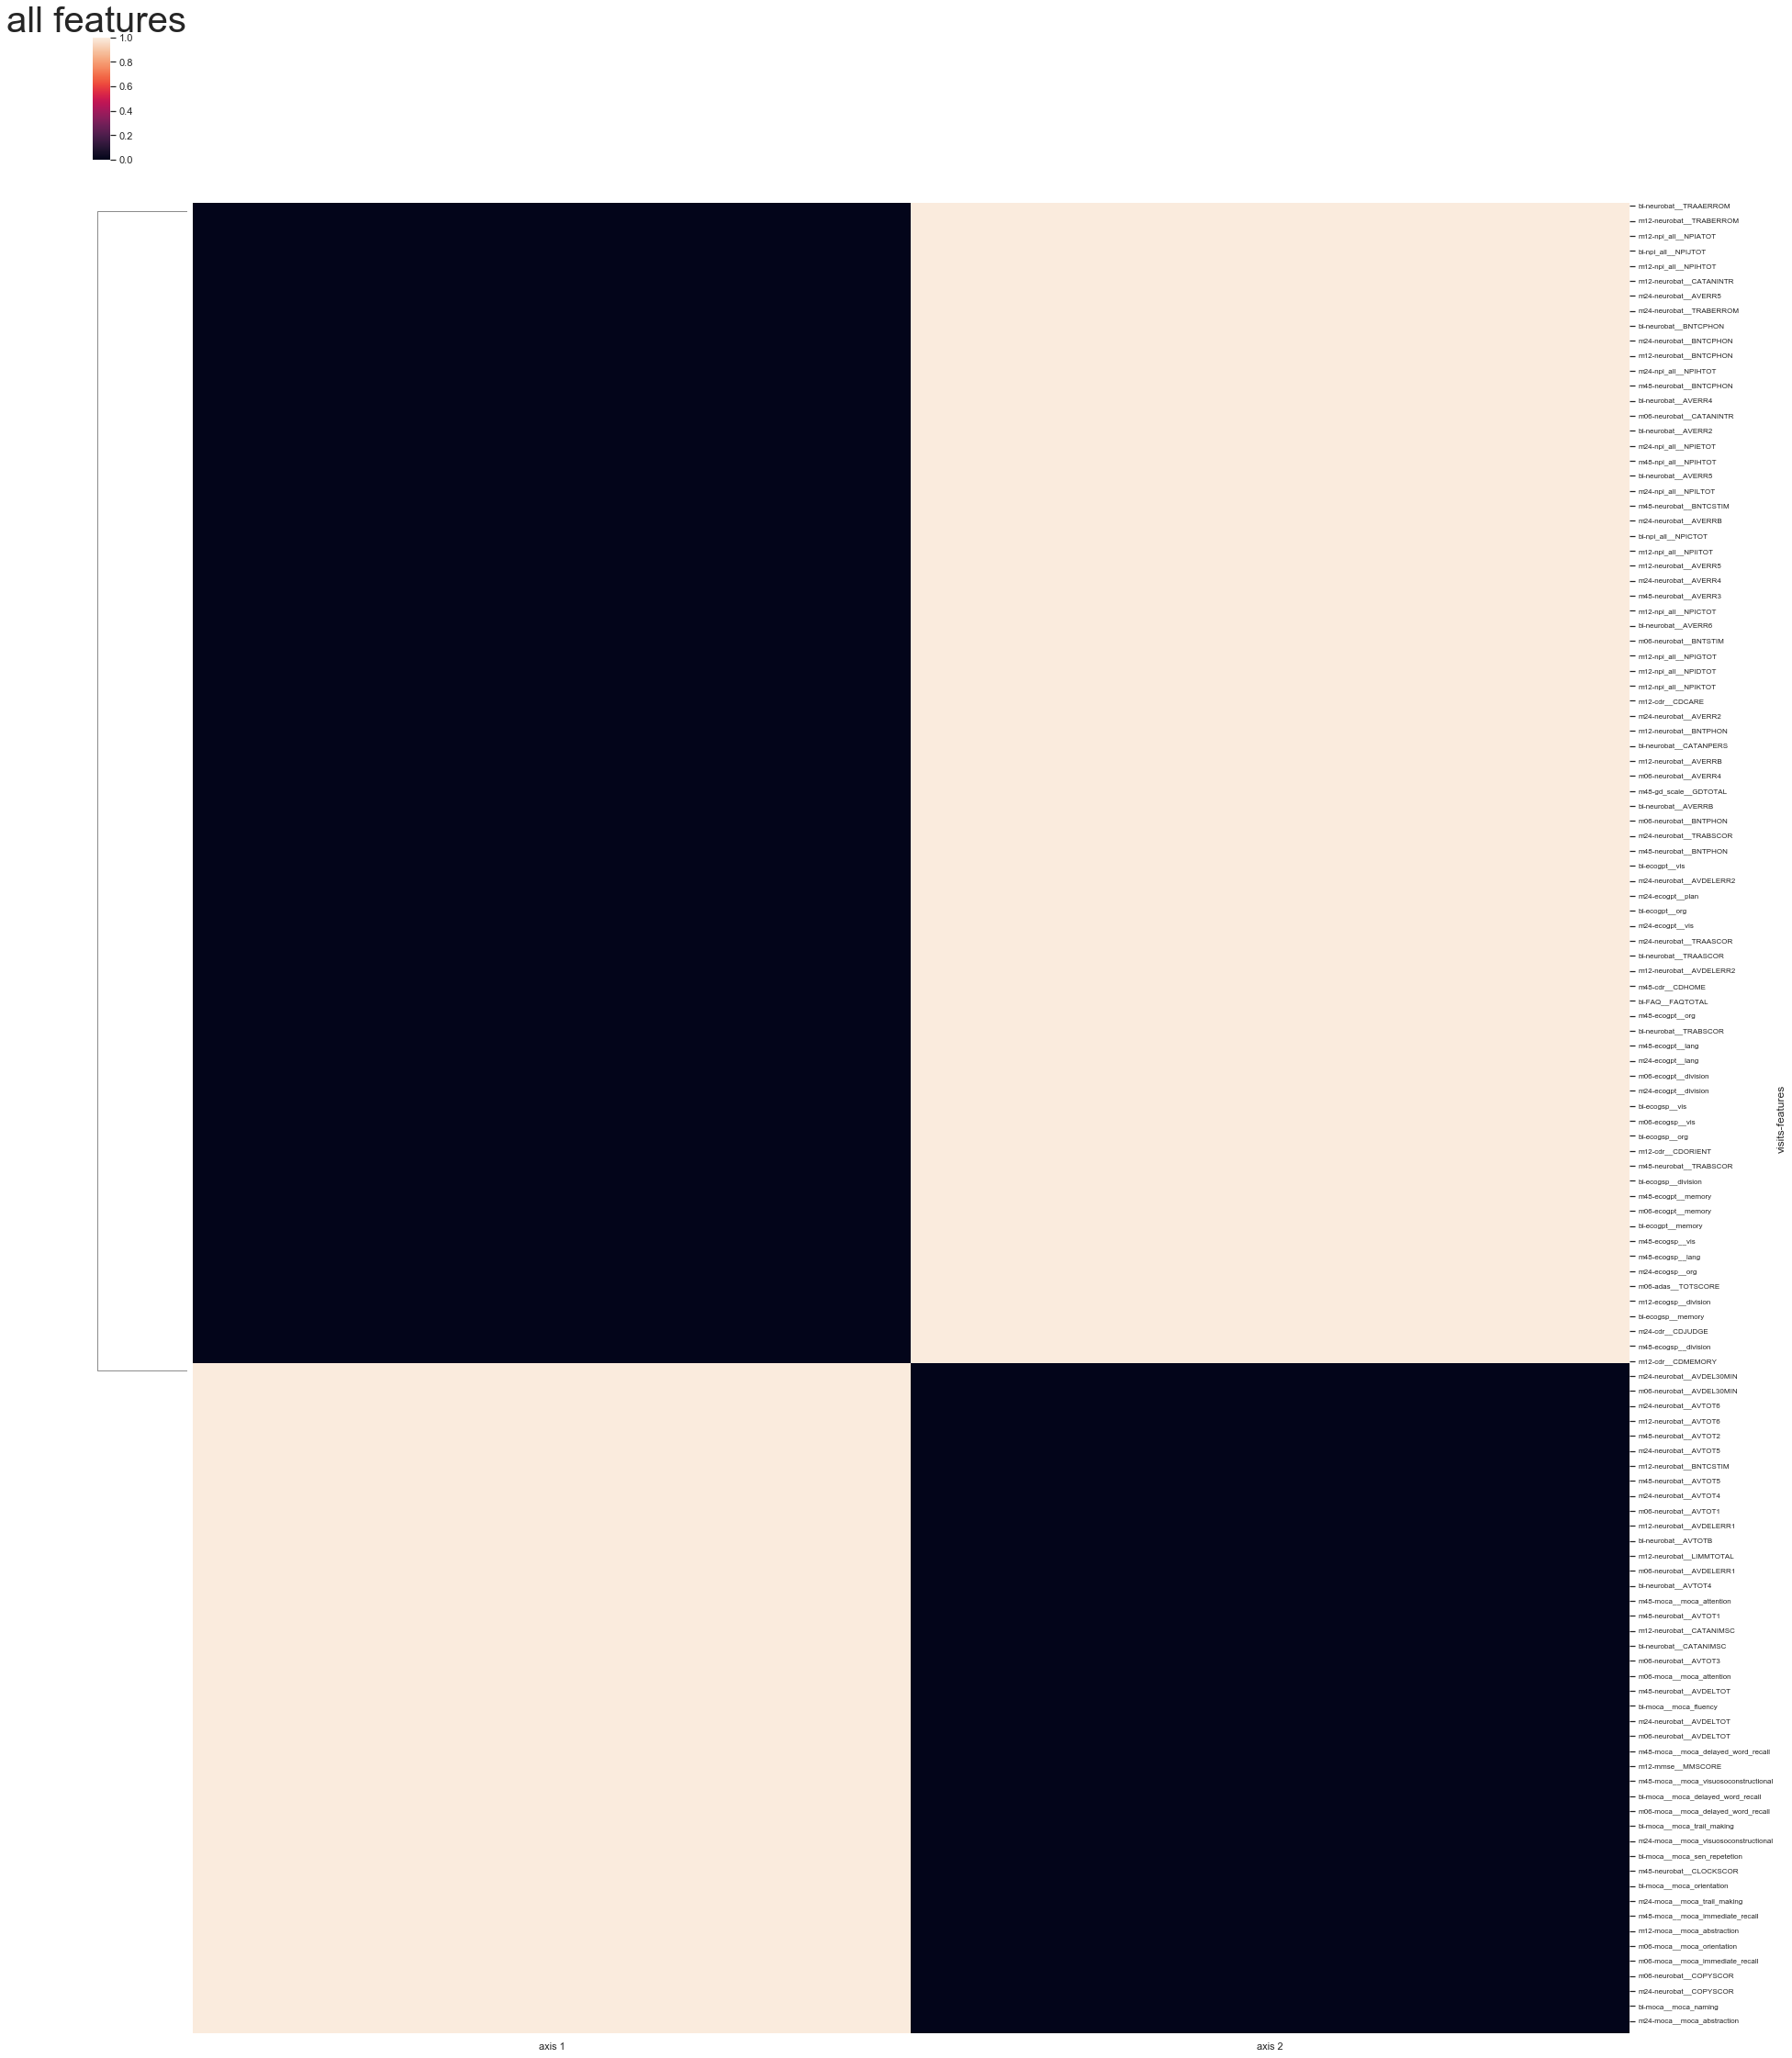

In [22]:
data = data.loc[ data.index.isin(list(  M_chosen_item_24.index   )) , :  ]
M_W, colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3 = project_data(data, visit)
M_W.to_csv(address+'\\totalm24_m48.csv')
redued_item_24 = redued_item_24.loc[ redued_item_24.index.isin(list(  M_W.index   )) , :  ]
colors_categories_item_24 = colors_categories_item_24.loc[ colors_categories_item_24.index.isin(list(  M_W.index   ))   ]
colors_categories_item_24_age = colors_categories_item_24.copy()
M_chosen_item_24 = M_chosen_item_24.loc[ M_chosen_item_24.index.isin(list(  M_W.index   )) , :  ]
dignosis = dignosis.loc[ dignosis.index.isin(list(  M_W.index   )) , :  ]

#### Functions to plot data in different format

In [23]:
def plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.style.use('seaborn-whitegrid')
    mpl.rc('font', size= 40)
    mpl.rc('axes', titlesize= 40)
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f9 = plt.figure(figsize=(30,20))
    f9.suptitle("Alzheimer's Progression Space at 48th month", fontsize = 40)
    ax3 = f9.add_subplot(1, 2, 1)
    ax4 = f9.add_subplot(1, 2, 2)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.5, s = 700)
    ax3.grid(True)
    ax3.set_xlabel('Cognitive decline', fontsize = 40)
    ax3.set_ylabel('Memory decline', fontsize = 40)
    ax3.set_title(" Classification by Algorithm ", fontsize = 40)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('Slow','Moderate','Fast'), loc='best', fontsize = 40)
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    ax4.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24, alpha=0.5, s = 700)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    ax4.legend((p1,p2,p3), ('Control','MCI','Dementia'), loc='best', fontsize = 40);
    ax4.grid(True)
    ax4.set_xlabel('Cognitive decline', fontsize = 40)
    ax4.set_ylabel('Memory decline', fontsize = 40)
    ax4.set_title(" Original Labels", fontsize = 40)
    plt.setp(ax4.get_xticklabels(), fontsize= 26)
    plt.setp(ax4.get_yticklabels(), fontsize= 26)
    plt.setp(ax3.get_xticklabels(), fontsize= 26)
    plt.setp(ax3.get_yticklabels(), fontsize= 26)
    plt.savefig(address +'\\paper_fig\\'+ 'nmf_side_by_side_48.png',dpi = 200)
    
def plot_nmf_gmm(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.style.use('seaborn-whitegrid')
    mpl.rc('font', size= 40)
    mpl.rc('axes', titlesize= 40)
    Predict1 = Predict.copy(deep = True)
    f11 = plt.figure(figsize=(15,20))
    f11.suptitle("Alzheimer's Progression Space at 48th month", fontsize = 40)
    ax5 = f11.add_subplot(1, 1, 1)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax5.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.5, s = 700)
    ax5.grid(True)
    ax5.set_xlabel('Cognitive decline', fontsize = 40)
    ax5.set_ylabel('Memory decline', fontsize = 40)
    ax5.set_title(" Classification by Algorithm ", fontsize = 40)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax5.legend((p1,p2,p3), ('Slow','Moderate','Fast'), loc='best')
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.setp(ax5.get_xticklabels(), fontsize= 26)
    plt.setp(ax5.get_yticklabels(), fontsize= 26)
    plt.savefig(address + 'nmf_one.png',dpi = 50)      
    
    
def projections_plain(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.style.use('seaborn-whitegrid')
    mpl.rc('font', size= 40)
    mpl.rc('axes', titlesize= 40)
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f9 = plt.figure(figsize=(15,20))
    f9.suptitle("Alzheimer's Progression Space at 48th month", fontsize = 40)
    ax4 = f9.add_subplot(1, 1, 1)
    ax4.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24, alpha=0.5, s = 700)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    ax4.legend((p1,p2,p3), ('Control','MCI','Dementia'), loc='best', fontsize = 40);
    ax4.grid(True)
    ax4.set_xlabel('Cognitive decline', fontsize = 40)
    ax4.set_ylabel('Memory decline', fontsize = 40)
    ax4.set_title(" Original Labels", fontsize = 40)
    plt.setp(ax4.get_xticklabels(), fontsize= 26)
    plt.setp(ax4.get_yticklabels(), fontsize= 26)
    plt.savefig(address + 'nmf_side_by_side.png',dpi = 200)   
    
    

def plot_side_by_side_3d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.rc('font', size= 18)
    mpl.rc('axes', titlesize= 18)
    
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f10 = plt.figure(figsize=(20,15))
    f10.suptitle("Classification by Algorithm", fontsize = 18)
    ax3 = plt.axes(projection='3d')
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_3_1']], M_mci_dem_nmf_proj[['NMF_3_2']],M_mci_dem_nmf_proj[['NMF_3_3']] ,c = colors.iloc[:,0], alpha=0.8)
    ax3.grid(True)
    ax3.set_xlabel('Cognition', fontsize = 18)
    ax3.set_ylabel('Memory and Depression ', fontsize = 18)
    ax3.set_zlabel('Memory and Depression', fontsize = 18)
    ax3.view_init(30, 30)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('Slow','Moderate','Fast'), loc='best')
    ax3.view_init(30, 30)
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.savefig(address + 'nmf_side_by_side_3d_original.png',dpi = 200)

#### Applying Gmm on (mci and demenntia patents ) to find slow, fast and moderate subtypes

In [24]:
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

#  Function to organize color sequence as per slow, medium and fast
#  This will make sure that 0 is corresponds to slow, 1 corresponds to moderate and 2 corresponds to fast
def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort_values([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)

# taking only mci and dementia patents
M_mci_dem_nmf_proj = M_W.loc[ M_W.index.isin( (redued_item_24.loc[ redued_item_24.DXCHANGE.isin([2,3]) , :].index ) )   ]
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())

Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)


2    44
0    42
1    38
Name: 0, dtype: int64


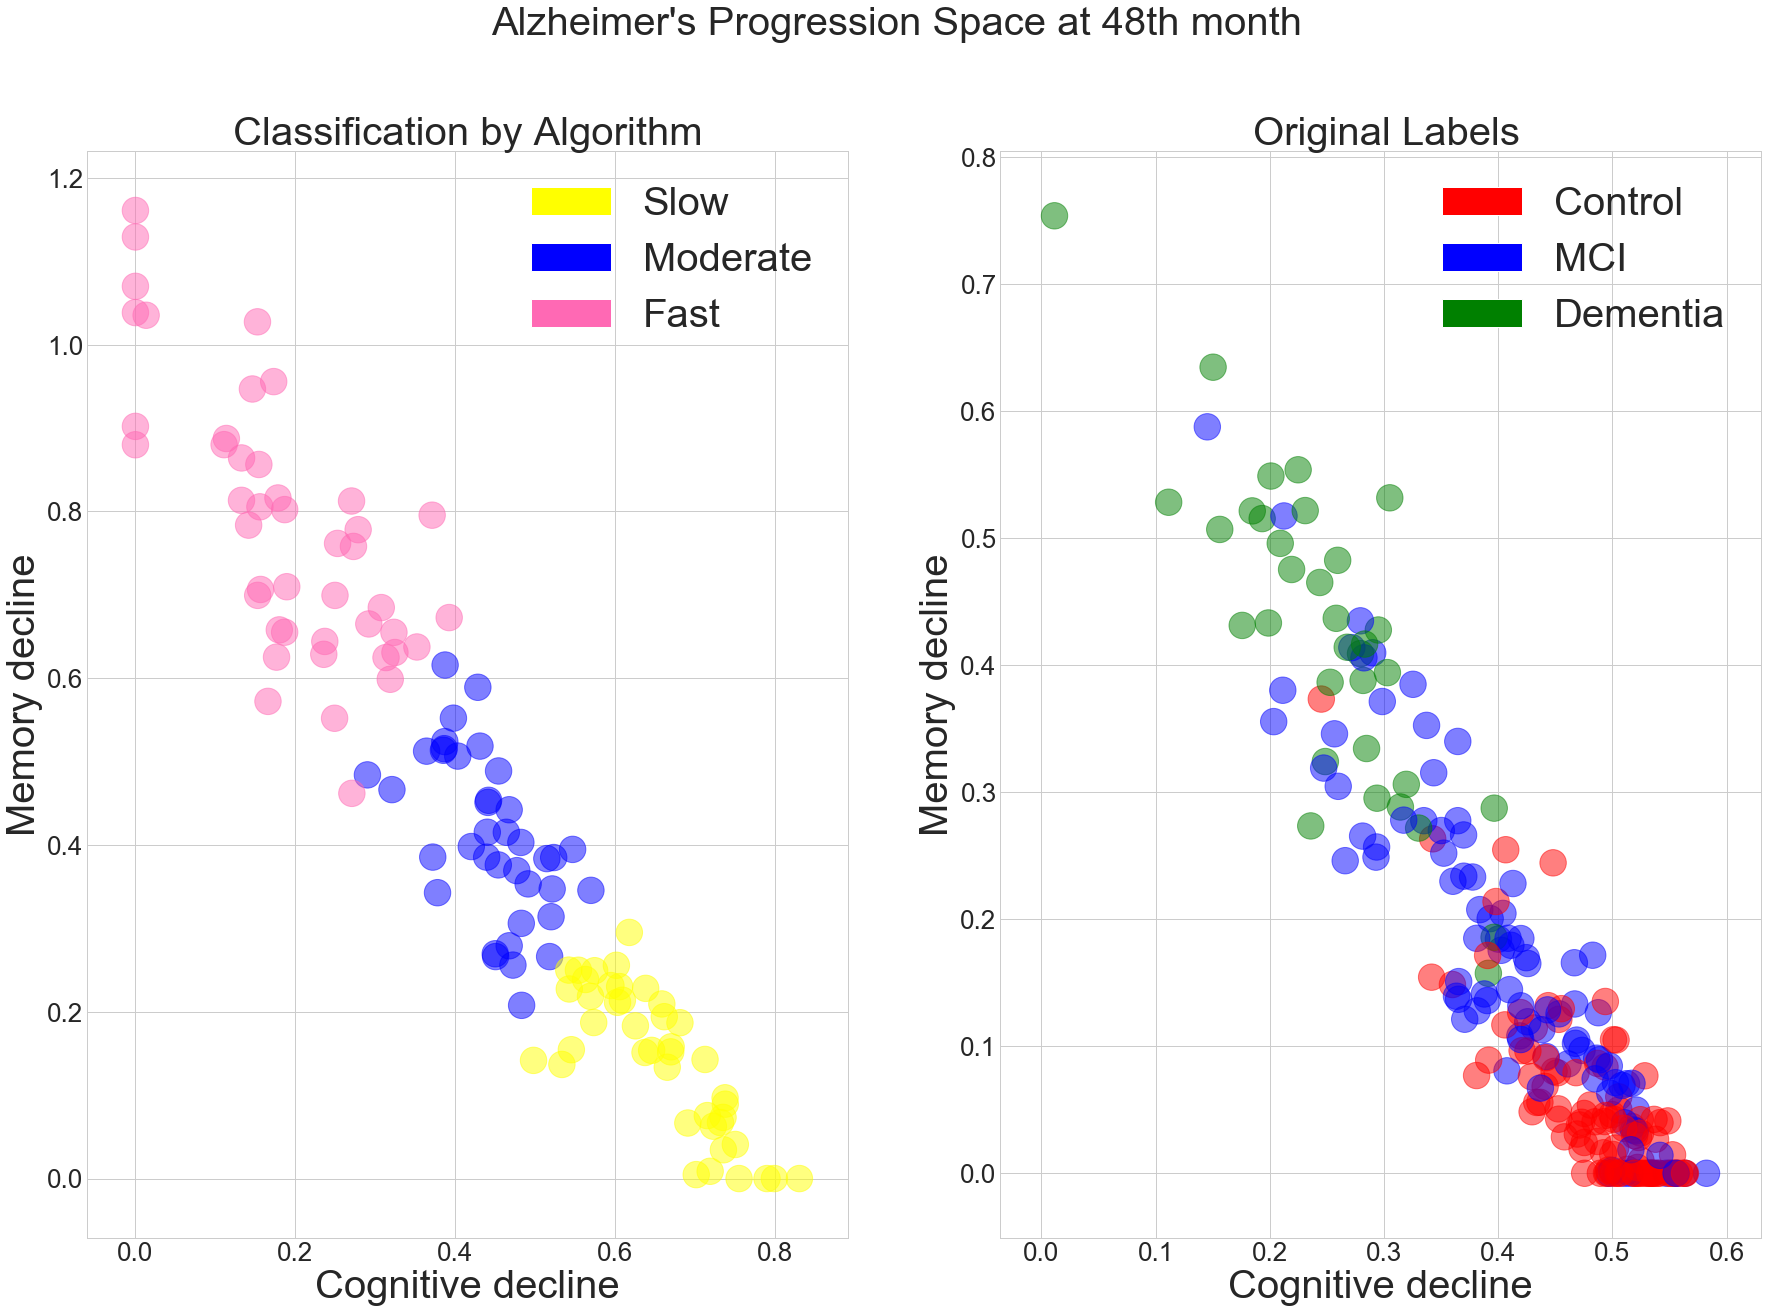

In [25]:
plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')       

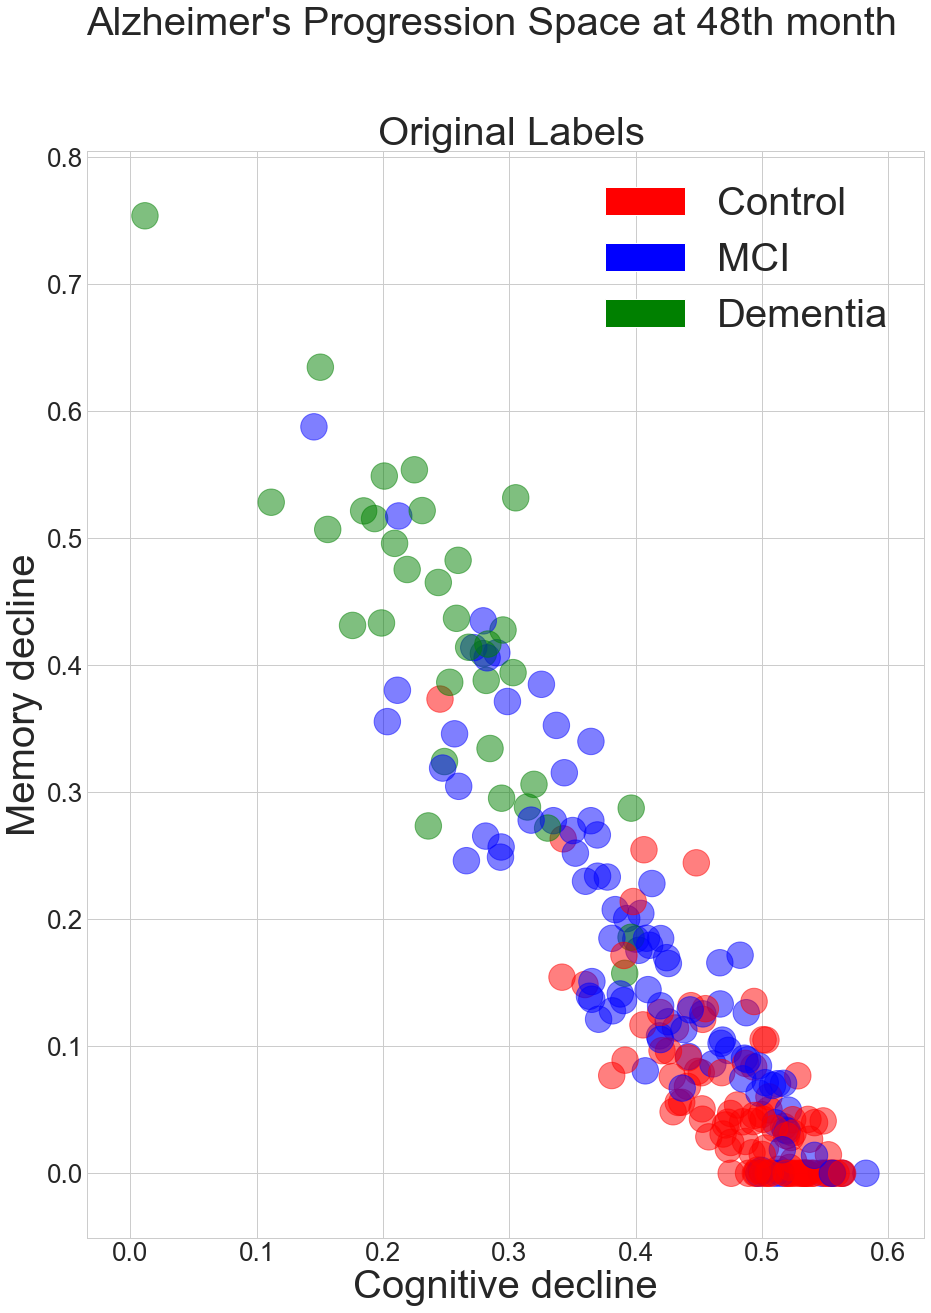

In [26]:
projections_plain(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')       

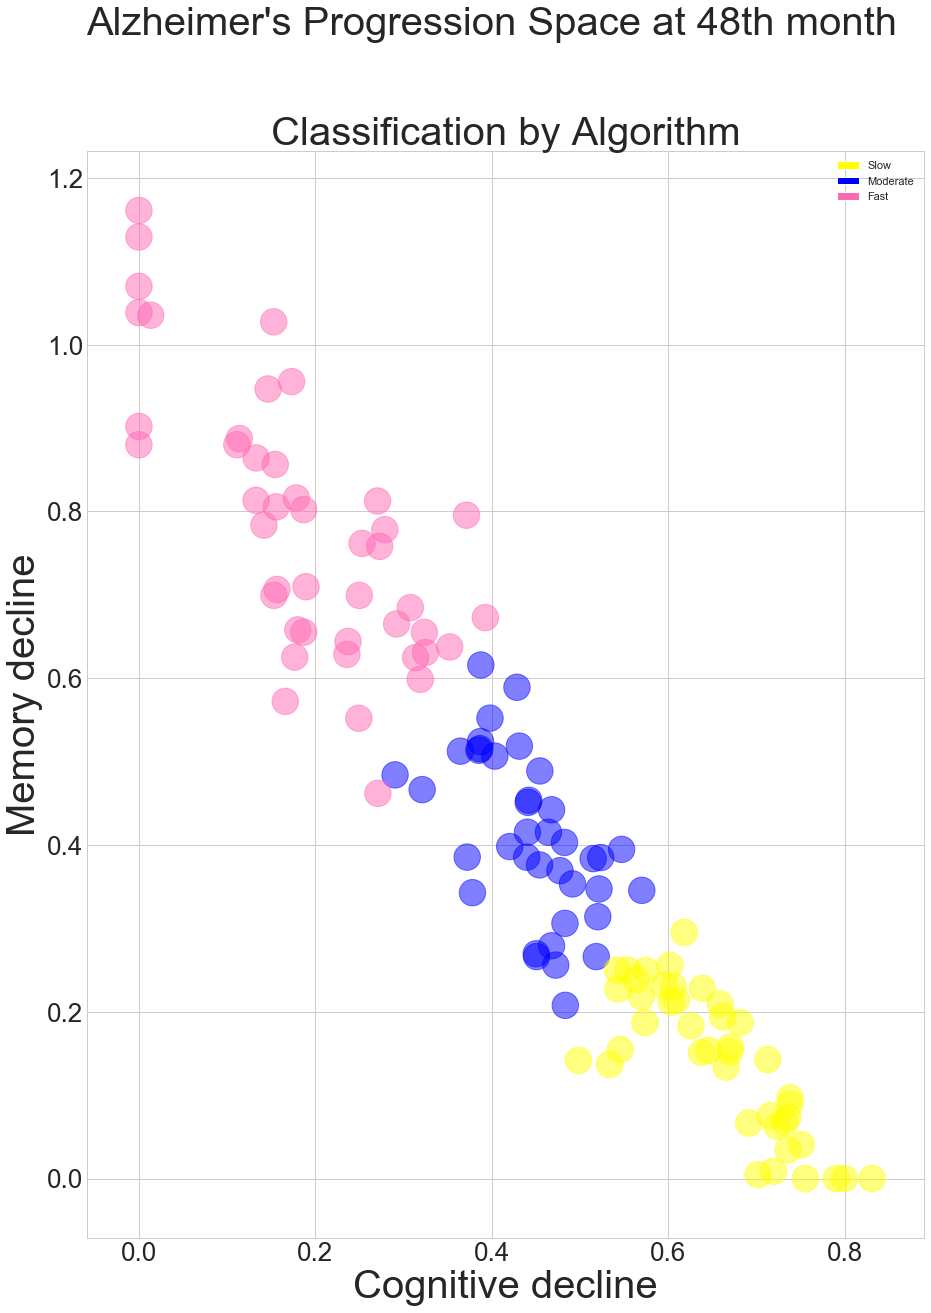

In [27]:
plot_nmf_gmm(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')   

### Some analysis of distribution of identified subtypes

In [28]:
M_mci_dem_nmf_proj['predicted'] = Predict_gmm.iloc[:,0]
data_original_label = redued_item_24.copy()
data_predicted_label = Predict_gmm.copy()
data_predicted_label.columns = ['Predicted']
data_predicted_label.Predicted = data_predicted_label.Predicted.replace([0,1,2],['Slow','Moderate','Fast'])
data_original_label.DXCHANGE = data_original_label.DXCHANGE.replace([1,2,3],['Control','MCI','Dementia'])
data_original_label = data_original_label.merge( data_predicted_label, how = 'inner',left_index=True, right_index=True)
data_original_label['count'] = 1
data_original_label.groupby(['DXCHANGE' , 'Predicted'])['count'].count()

DXCHANGE  Predicted
Dementia  Fast         32
          Moderate      2
MCI       Fast         12
          Moderate     36
          Slow         42
Name: count, dtype: int64

In [29]:
# Merging predicted labels with the data being used in prediction
data_prediction_original_1 = M_chosen_item_24
data_prediction_original = pd.merge(data_prediction_original_1,pd.DataFrame(M_mci_dem_nmf_proj['predicted']),left_index = True, right_index = True, how='inner')


### Verifying that 3 is optimul number of clusters using BIC

[ -160.83413147  -172.55036143 -1647.2459292  -1627.68868435
 -1639.79571576 -1620.71108193 -1617.58484623]


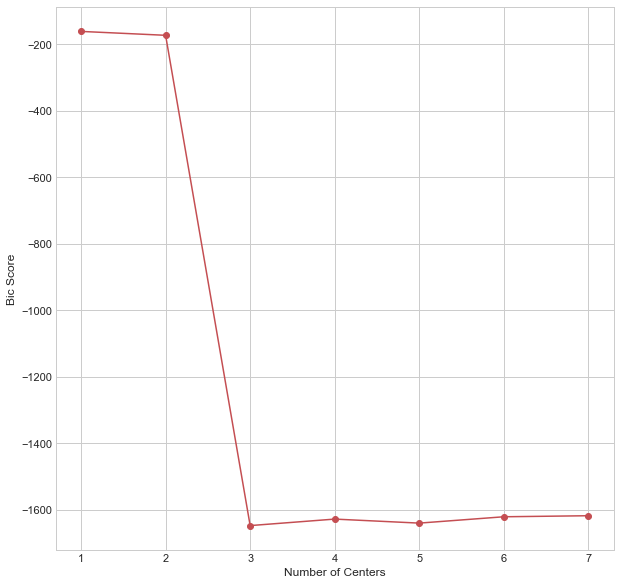

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
Nclusters = np.arange(1, 8)
# find best number of clusters via BIC
clfs = [mixture.GaussianMixture(n_components=N, covariance_type='tied').fit(M_mci_dem_nmf_proj) for N in Nclusters]
BICs = np.array([clf.bic(M_mci_dem_nmf_proj) for clf in clfs])
clf = clfs[np.argmin(BICs)]
print(BICs)
# scatter the points
ax.plot(Nclusters, BICs, 'ro-')
plt.xlabel('Number of Centers')
plt.ylabel('Bic Score')
plt.savefig(address + 'bic_48.png',dpi = 200)  
plt.show()

### Plotting the distribution of subtypes along x and y axis

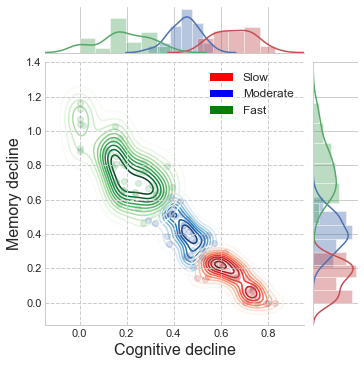

In [31]:
colors_categories_item_24 = pd.DataFrame(colors_categories_item_24)

x_red = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([0]),'NMF_2_1']
y_red = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([0]),'NMF_2_2']

x_blue = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([1]),'NMF_2_1']
y_blue = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([1]),'NMF_2_2']

x_green = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([2]),'NMF_2_1']
y_green = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([2]),'NMF_2_2']
plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0

p = sns.JointGrid(x = x_blue, y = y_blue , size=6)
p.x = list(x_blue)
p.y = list(y_blue)
p = p.plot_joint(plt.scatter, c="b", alpha = a)
# p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
# p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = list( x_red)
p.y = list( y_red)
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

p.x = list( x_green)
p.y = list( y_green)
p.plot_joint(plt.scatter, c="g", alpha = a)
p.plot_marginals(sns.distplot, color='g', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
plt.grid()

p.set_axis_labels(xlabel='Cognitive decline', ylabel='Memory decline')
# p.ax_joint.set_xticklabels([])
# p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
plt.legend((p1, p2, p3), (  'Slow','Moderate','Fast' ), loc='best',prop={'size':12});
plt.xlabel('Cognitive decline', fontsize = 16)
plt.ylabel('Memory decline', fontsize = 16)
plt.grid(linestyle='--')
p.savefig(address +'\\paper_fig\\'+'gmm_original_joint_plot_48.png',dpi = 200)

### Predicting fast , slow and medium subtypes in data



Shape of data is (124, 220)
Distributoion of slow fast and moderate in data 
2    44
0    42
1    38
Name: predicted, dtype: int64
Nearest Neighbors
[0.73076923 0.84615385 0.76       0.70833333 0.82608696]
#####################
Linear SVM
[0.76923077 0.96153846 0.88       0.70833333 0.82608696]
#####################
RBF SVM
[0.34615385 0.34615385 0.36       0.375      0.34782609]
#####################
Decision Tree
[0.5        0.84615385 0.72       0.83333333 0.7826087 ]
#####################
AdaBoost
[0.76923077 1.         0.88       0.75       0.91304348]
#####################
Naive Bayes
[0.61538462 0.57692308 0.68       0.66666667 0.43478261]
#####################
Linear Discriminant Analysis
[0.65384615 0.84615385 0.76       0.75       0.7826087 ]
#####################
Quadratic Discriminant Analysis
[0.65384615 0.76923077 0.76       0.75       0.82608696]
#####################
Logistic Regression
[0.46153846 0.42307692 0.4        0.41666667 0.65217391]
#####################
Ran

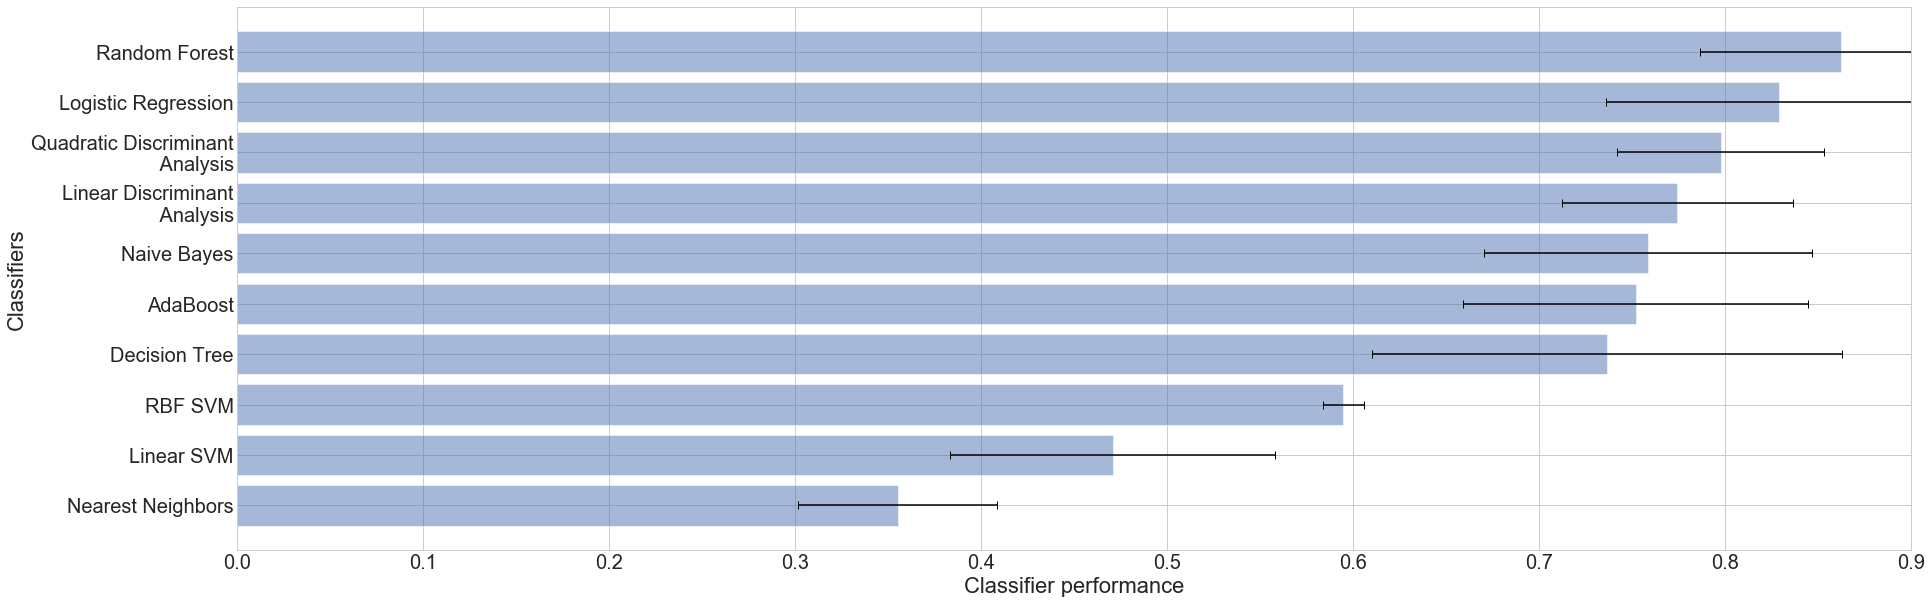

In [32]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis", "Logistic Regression"
         , "Random Forest"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(n_estimators = 40)]

# considering low mci and control same 
data_prediction1 = data_prediction_original.copy(deep = True)
# data_prediction1['predicted'] = data_prediction1['predicted'].replace([3],[3])
# del data_prediction1['predicted'] 

# Predict_gmm = Predict_gmm.rename(columns={0: "predicted"})
# data_prediction1 = pd.merge(data_prediction1,Predict_gmm,left_index = True, right_index = True, how='outer')
# data_prediction1 = data_prediction1.fillna(3)

X_train, X_test, y_train, y_test = train_test_split(data_prediction1.iloc[:,0:-1], data_prediction1['predicted'], test_size=0.2, random_state=42)

x_full = data_prediction1.iloc[:,0:-1]
y_full = data_prediction1['predicted']
print('\n')
print( f'Shape of data is {data_prediction1.shape}' )
print( f'Distributoion of slow fast and moderate in data ' )
print(data_prediction1['predicted'].value_counts())
scores1 = []
score_entry = {}
y_pred = {}
 
list_of_names = []
mean_scores = []
standard_devi = []

for name, clf in zip(names, classifiers):
    pipeline = Pipeline([(name, clf)])
    scores = cross_val_score(pipeline, x_full, y_full, scoring='accuracy', cv=5)
    list_of_names.append(name)
    mean_scores.append( scores.mean() )
    standard_devi.append( scores.std() )
    print(name)
    print(scores)
    print('#####################')

mean_scores, names = zip(*sorted(zip(mean_scores, names)))
fig, ax = plt.subplots( figsize=(30, 10) )
ax.barh(  np.arange(len(names)),mean_scores, xerr=standard_devi, align='center', alpha=0.5, ecolor='black', capsize=4)
ax.set_xlabel('Classifier performance', fontsize = 22)
ax.set_ylabel('Classifiers', fontsize = 22)
plt.xlim( ([0.0,0.90]) )
ax.set_yticks(np.arange(len(names)))

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "AdaBoost", "Naive Bayes", "Linear Discriminant\n Analysis",
         "Quadratic Discriminant\n Analysis", "Logistic Regression"
         , "Random Forest"]
ax.set_yticklabels(names,rotation=0 , fontsize = 20 )
ax.set_xticklabels( [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize = 20 )
ax.xaxis.grid(True)
# plt.title('Comparision of different classifiers for prediction at m48 considering baseline and m12', fontsize = 28)
fig.savefig(address +'\\paper_fig\\'+ 'accuracy24.png',dpi = 200)
fig.show()

In [33]:
pipeline = Pipeline([('classifier', RandomForestClassifier())])
'''
you can also specify classifications models here
'''
grid = {
    'classifier__n_estimators': [5,10,15,20,25,30,35,40,45,50],\
    'classifier__max_depth' : [5,10,15,20,25,30,35,40,45,50],\
    'classifier__class_weight': [None, 'balanced'],\
    'classifier__max_features': ['auto','sqrt','log2', None],\
    'classifier__random_state' : [0],  
    'classifier__min_samples_leaf':[1,2,3,0.1,0.05,0.01]
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=1, cv=5)
grid_search.fit(X=x_full, y=y_full)
d = grid_search.best_params_
# d = {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 25, 'classifier__random_state': 0}

print("-----------")
print("-----------")
print('best score\n')
print(grid_search.best_score_)
print('best_params\n')
print(grid_search.best_params_)
print(grid_search.best_index_)
print(f"Mean cv accuracy on test set {grid_search.cv_results_['mean_test_score'][grid_search.best_index_]} \n")
print(f"Standard deviation on test set {grid_search.cv_results_['std_test_score'][grid_search.best_index_]} \n")
print(f"Mean cv accuracy on train set {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]} \n")
print(f"Standard deviation on train set {grid_search.cv_results_['std_train_score'][grid_search.best_index_]} \n")
print(grid_search.best_score_)
ci95_low = grid_search.cv_results_['mean_test_score'][grid_search.best_index_] - (1.96*  grid_search.cv_results_['std_test_score'][grid_search.best_index_]/ math.sqrt(5) )
ci95_hi = grid_search.cv_results_['mean_test_score'][grid_search.best_index_] + (1.96*  grid_search.cv_results_['std_test_score'][grid_search.best_index_]/ math.sqrt(5) )
print(f"95 % CI {ci95_low} and {ci95_hi} \n")

-----------
-----------
best score

0.8548387096774194
best_params

{'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 35, 'classifier__random_state': 0}
366
Mean cv accuracy on test set 0.8548387096774194 

Standard deviation on test set 0.06476912132301592 

Mean cv accuracy on train set 1.0 

Standard deviation on train set 0.0 

0.8548387096774194
95 % CI 0.7980660716939111 and 0.9116113476609277 



## Making AUC curve

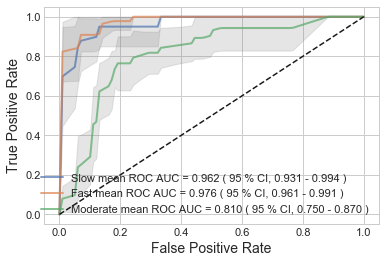

In [34]:
# 5 fold cv

X,Y = data_prediction1.iloc[:,0:-1],data_prediction1['predicted']
n_classes = y_train.unique()
cv = StratifiedKFold(n_splits=5)
for k in n_classes:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X,Y):
            pipeline = Pipeline([('classifier', RandomForestClassifier(max_features= d['classifier__max_features'],min_samples_leaf=d['classifier__min_samples_leaf'] ,  n_estimators=d['classifier__n_estimators'], max_depth= d['classifier__max_depth'],class_weight=d['classifier__class_weight'], random_state= d['classifier__random_state'] ))])
            pipeline.fit(X.iloc[train], Y.iloc[train]==k)
            preds  = pipeline.predict_proba(X.iloc[test])
            label =  Y.iloc[test] == k
            fpr, tpr, _ = metrics.roc_curve(label, preds[:,1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = metrics.auc(fpr, tpr)
            aucs.append(roc_auc)
            i += 1
            
    class_name = 'Controls' if k==3 else 'Slow' if k==0 else 'Moderate' if k==1 else 'Fast'
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ci95_hi = f'{mean_auc + 1.96*(std_auc/ math.sqrt( len(aucs)) ):.3f}' 
    ci95_low = f'{mean_auc - 1.96*(std_auc/ math.sqrt( len(aucs)) ):.3f}'
#     plt.plot(mean_fpr, mean_tpr,label= r'{0} mean ROC (AUC = {1:0.2f} $\pm$ {2:0.2f})'.format(class_name, mean_auc, std_auc) ,lw=2, alpha=.7)
    plt.plot(mean_fpr, mean_tpr,label= f'{class_name} mean ROC AUC = {mean_auc:.3f} ( 95 % CI, {ci95_low} - {ci95_hi} )' ,lw=2, alpha=.7)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

plt.figure(1, figsize=(18, 18))
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.025, 1.025])
# plt.ylim([-0.025, 1.025])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(address +'\\paper_fig\\'+ 'auc_48.png',dpi = 200)
plt.show()

## Ploting Reversion 

In [35]:

# Following functions are helper functions used to plot reversions. Their use id to subset data and provide list of colors 

def project_data_CN_MCI_DMN_edgecolors(M_chosen, visit, list_months_to_be_considered):

    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
                                               'Stable: Dementia', 'Stable: Dementia to Dementia',\
                                               'Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia',\
                                               'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    list_of_colors = ['red', 'blue', 'green']
    return redued, colors_categories, M_chosen,dignosis, list_of_colors






def project_list_of_colors(M_chosen, visit, list_months_to_be_considered):

    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    M_H_T.to_csv(address + "all_2d_list.csv") 
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]    
    redued['DXCHANGE_2'] = redued.DXCHANGE
    redued['DXCHANGE_original'] = redued.DXCHANGE
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    redued.DXCHANGE_2 = redued.DXCHANGE_2.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
#     redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
#     colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    redued.DXCHANGE  = redued.DXCHANGE.replace( [1,1,2,2,3,3,4,5,6,7,8] , ['#377eb8', '#377eb8', '#ff7f00', '#ff7f00', '#4daf4a', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999','#e41a1c' ] )
    colors_categories = redued.DXCHANGE
    list_of_colors = ['#377eb8', '#377eb8', '#ff7f00', '#ff7f00', '#4daf4a', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999','#e41a1c' ]                                            
    list_prog = ['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI','Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL','Reversion: Dementia to MCI']
    list_replace = [1,1,2,2,3,3,4,5,6,7,8]
    return redued, colors_categories, M_chosen,dignosis, list_of_colors,list_prog,list_replace

    
    

    

    

    
    
    
    
    

In [36]:
list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm48'
redued_item_CN_MCI_DMN, colors_categories_item_CN_MCI_DMN, M_chosen_item_CN_MCI_DMN,dignosis_CN_MCI_DMN,list_of_colors_CN_MCI_DMN = project_data_CN_MCI_DMN_edgecolors(M_chosen_item_24 , visits, list_months_to_be_considered)

list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm48'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis,list_of_colors ,list_prog, list_replace= project_list_of_colors(M_chosen_item_24 , visits, list_months_to_be_considered)
print('************************')
print('Number of observations :')
print(len(redued_item_24))
# print(redued_item_24['DXCHANGE'].unique())
print('************************')



************************
Number of observations :
223
************************


In [37]:
# Actual functions used to project 2 kind of reversion son same graph 'MCI to Control' and 'Dementia to MCI'

def projections_two(redued,colors_categories, colors_categories_item_CN_MCI_DMN,list_of_colors, list_prog,list_replace):
    redued.merge(colors_categories.to_frame(), left_index=True, right_index=True)  
    redued_1 = redued[ redued.DXCHANGE_2.isin([7,8])]
    colors_categories = redued_1['DXCHANGE']
    fig = plt.figure(4, figsize=(15,15))
    ax1 = fig.add_subplot(111)
    ax1.scatter(redued_1[['NMF_2_1']], redued_1[['NMF_2_2']], c = redued_1['DXCHANGE'], s=700, marker='v')
    #plt.title('Reversion: MCI to NL and Reversion: Dementia to MCI')
    ax1.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], edgecolors = colors_categories_item_CN_MCI_DMN, s= 700,facecolors='none', alpha = 0.5)#,linewidth= 1.5)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#999999')
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#e41a1c')
    plt.legend((p1, p2, p3, p4,p5), ('Control', 'MCI','Dementia', 'MCI to Control','Dementia to MCI' ), loc='best', fontsize = 22);
    plt.xlim((-.02, 0.75))
    plt.ylim((-.02, 0.9)) 
    plt.xlabel('Cognitive decline', fontsize = 28)
    plt.ylabel('Memory decline', fontsize = 28)
    plt.tick_params(labelsize=22)
    plt.grid(True)
    plt.savefig(address +'\\paper_fig\\'+ 'reversion_48.png',dpi = 200)
    plt.show()

In [38]:
# Actual functions used to project reversions
def projections_reversions(redued,colors_categories, colors_categories_item_CN_MCI_DMN,list_of_colors, list_prog,list_replace,show):
    redued.merge(colors_categories.to_frame(), left_index=True, right_index=True)
    if show == 'MCI to DEMENTIA':
        a = 7
    elif show== 'NL to Dementia':
        a = 8
    elif show== 'MCI to NL':
        a = 9
    elif show== 'Dementia to MCI':
        a = 10
    elif show== 'NL to MCI':
        a = 6    
    redued_1 = redued[ redued.DXCHANGE_2.isin([list_replace[a]])]
    colors_categories = redued_1['DXCHANGE']
    fig = plt.figure(4, figsize=(18,18))
    ax1 = fig.add_subplot(111)
    ax1.scatter(redued_1[['NMF_2_1']], redued_1[['NMF_2_2']], c = redued_1['DXCHANGE'], s=700, marker='v')
    plt.title(show, fontsize = 40)
    ax1.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], edgecolors = colors_categories_item_CN_MCI_DMN, s= 600,facecolors='none', alpha = 0.95)#,linewidth= 1.5)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc= list_of_colors[a])
    plt.legend((p1, p2, p3, p4), ('Control', 'MCI','Dementia', list_prog[a] ), loc='best', fontsize = 30);
    plt.xlim((-.02, 0.8))
    plt.ylim((-.02, 1.0)) 
    plt.xlabel('Cognition', fontsize = 40)
    plt.ylabel('Memory and Deprtession', fontsize = 40)
    plt.grid(True)
    plt.savefig(address + 'reversion_' + show + '_.png',dpi = 200)
    plt.show()

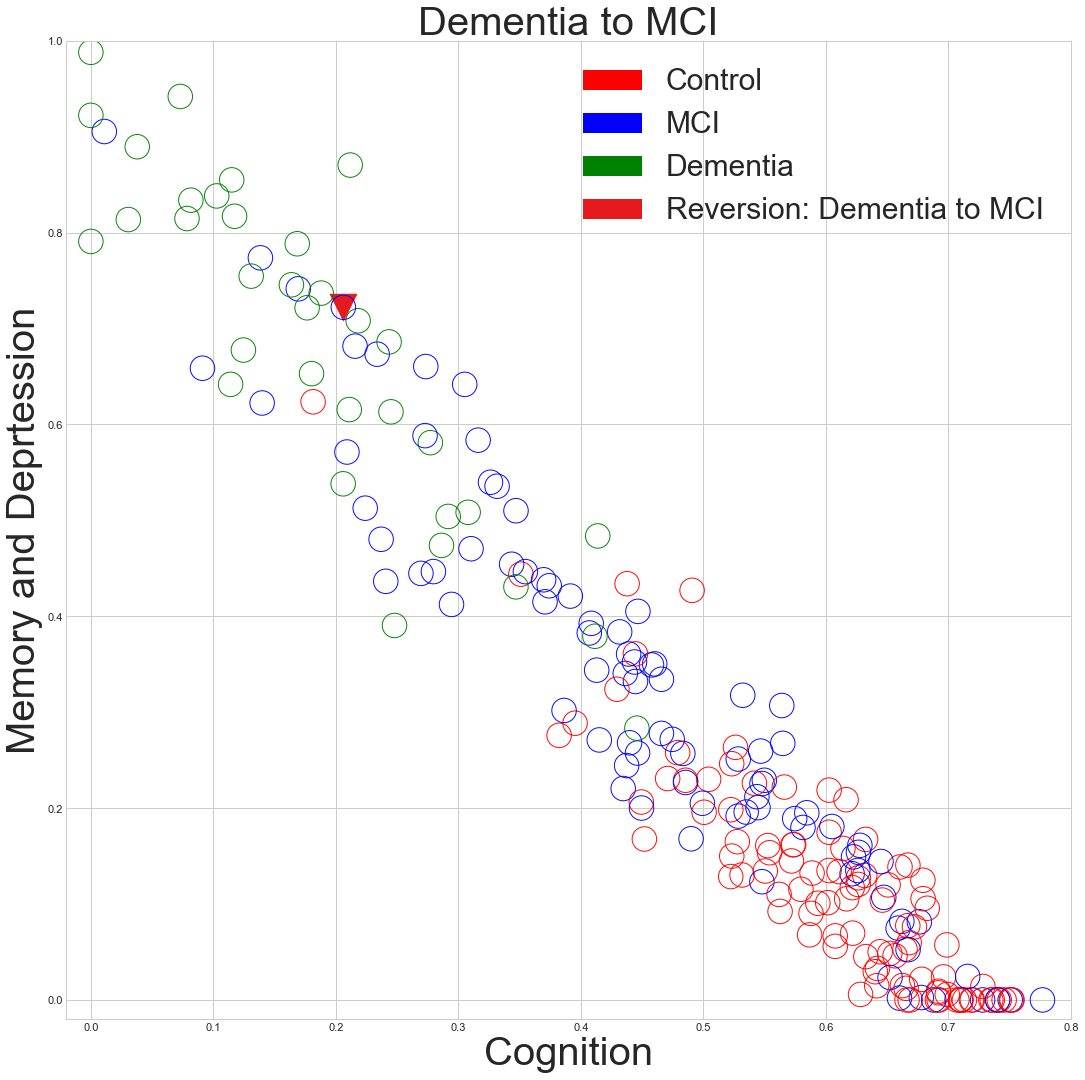

In [39]:
projections_reversions(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace, 'Dementia to MCI')

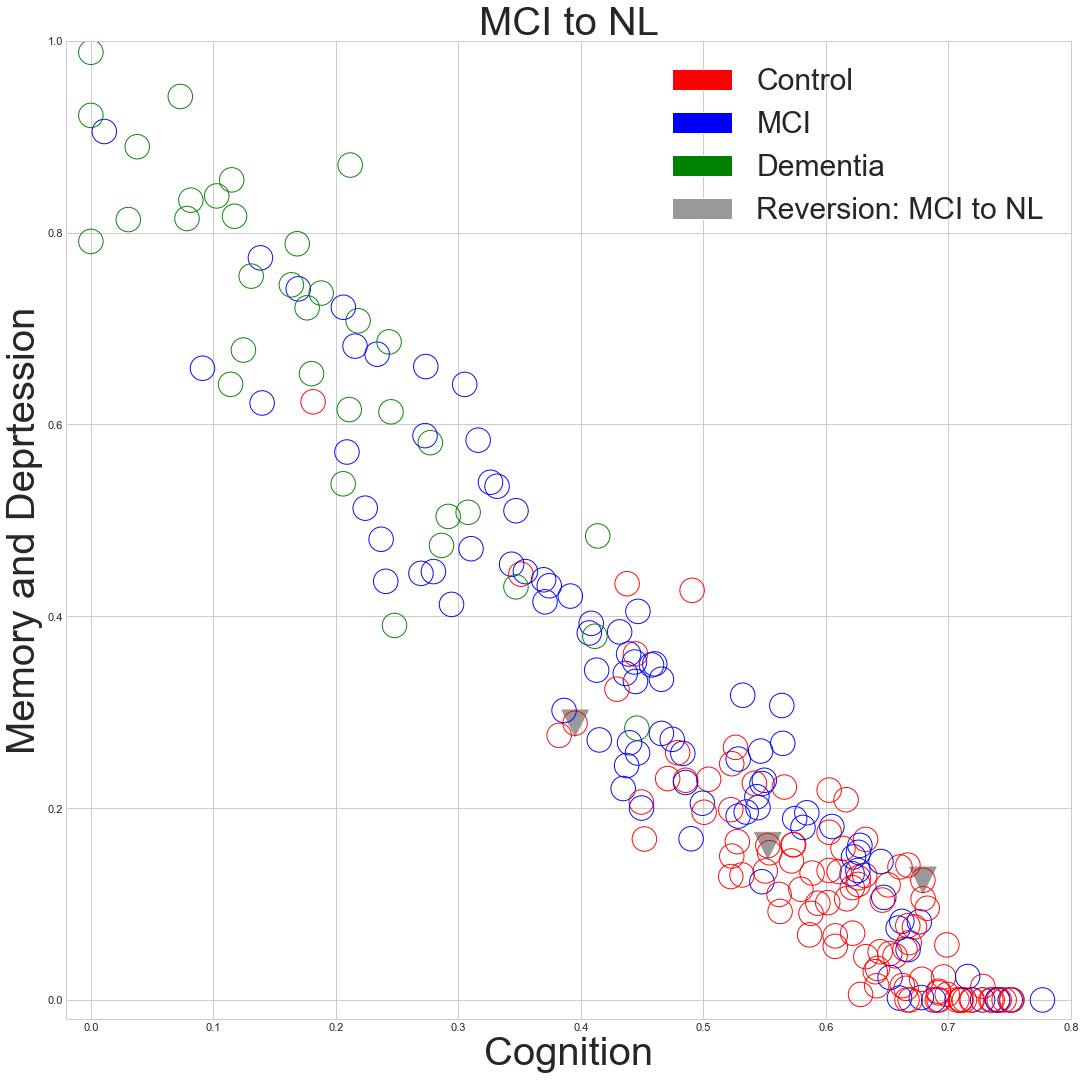

In [40]:
projections_reversions(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace, 'MCI to NL')

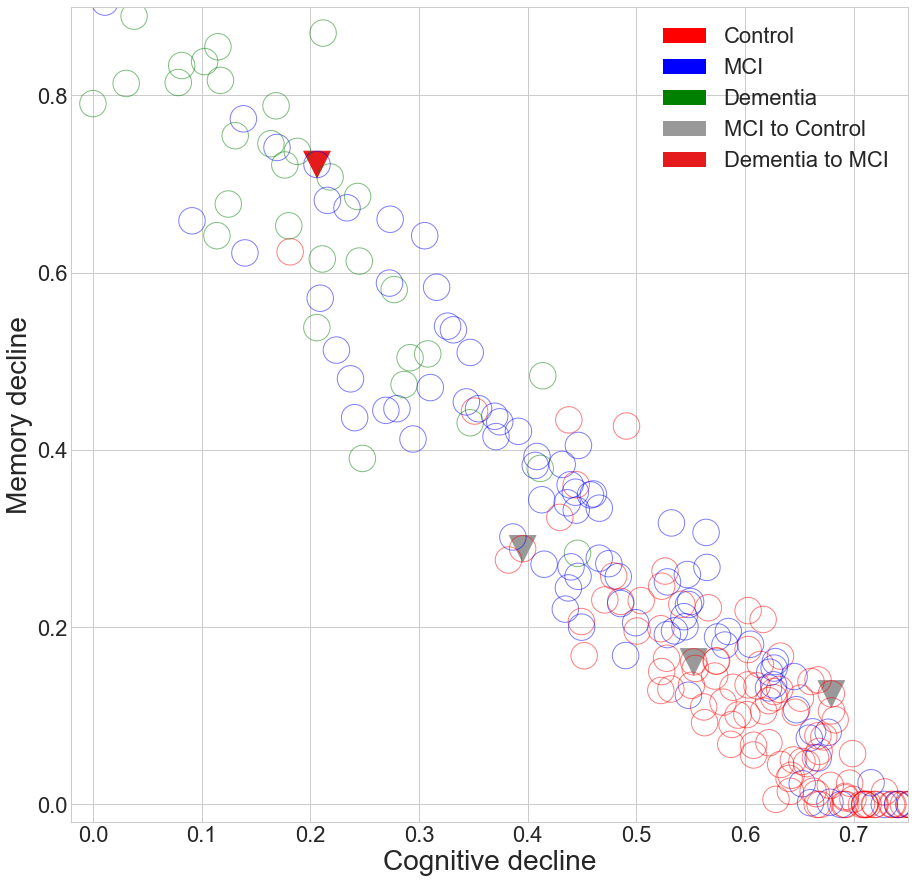

In [41]:

projections_two(redued_item_24,colors_categories_item_24, colors_categories_item_CN_MCI_DMN \
            ,list_of_colors,list_prog,list_replace)

#### Ploting distribution of control MCI and Dementia inprogression space

In [42]:
#VISUALISATIONS 
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])

#The patient who visited again and again in different VISCODES, keeping only the first visit
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] #CHANGE HERE FOR DIFFERENT DATASETS 

result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)


### Ploting Age Distribution

In [58]:
c =  colors_categories_item_24_age.T.squeeze()
#NMF and age distinction for controls 
controls_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='red']
controls_nmf_age = result['AGE'][controls_nmf.index] #Way 1 
#NMF and age distinction for MCI
mci_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='blue']
mci_nmf_age = result['AGE'][mci_nmf.index] #Way 1 
#NMF and age distinction for Dimentia
dimentia_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='green']
dimentia_nmf_age = result['AGE'][dimentia_nmf.index] #Way 1 

In [ ]:

model_gmm = mixture.GaussianMixture(n_components=2, covariance_type='full',  random_state = 0)
model_gmm.fit(controls_nmf) 
Predict_gmm = pd.DataFrame(model_gmm.predict(controls_nmf))
Predict_gmm.index = controls_nmf.index


a = pd.DataFrame(controls_nmf_age)
age1 = np.mean( a[(Predict_gmm==1).values] )

a = pd.DataFrame(controls_nmf_age)
age2 = np.mean( a[(Predict_gmm==0).values]  )

a1 = a[(Predict_gmm==1).values] 
a2 = a[(Predict_gmm==0).values] 
age1ci95_hi = np.float( np.mean(a1) + (1.96 * np.std(a1)/ math.sqrt( len(a1) ) ) )
age1ci95_lo = np.float(np.mean(a1) - (1.96 * np.std(a1)/ math.sqrt( len(a1) ) ) )

age2ci95_hi = np.float( np.mean(a2) + (1.96 * np.std(a2)/ math.sqrt( len(a2) ) ) )
age2ci95_lo = np.float( np.mean(a2) - (1.96 * np.std(a2)/ math.sqrt( len(a2) ) ) )



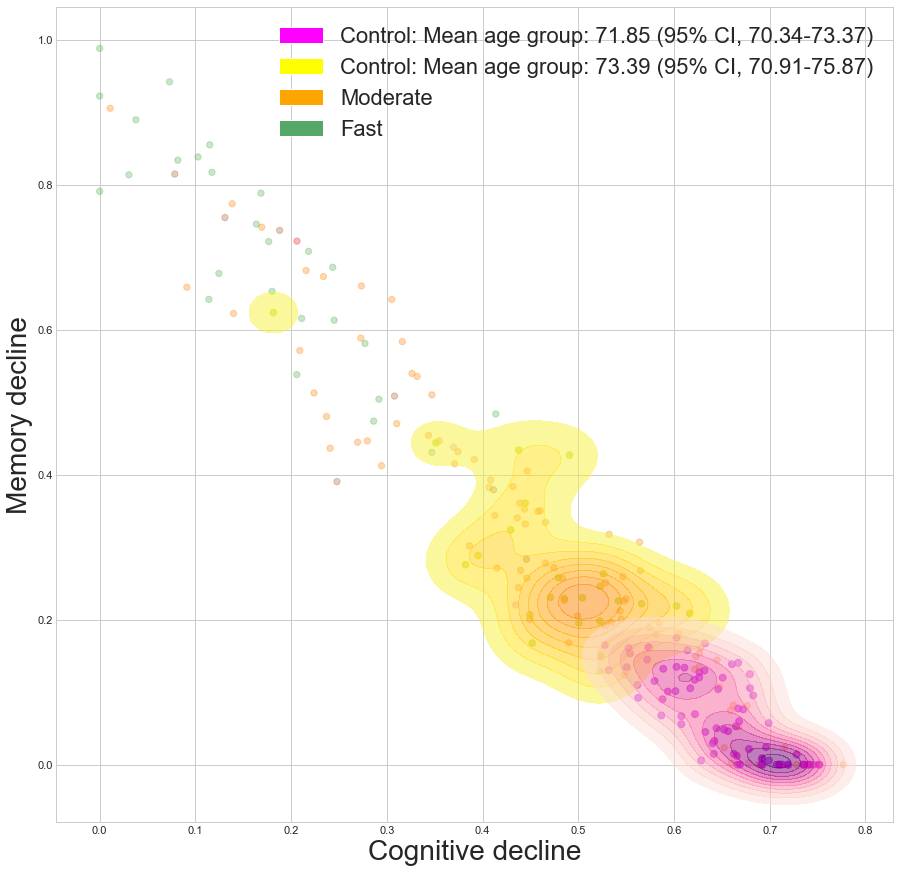

In [60]:
data = pd.concat( [controls_nmf, Predict_gmm], axis = 1)
mpl.rc('font', size= 18)
mpl.rc('axes', titlesize= 18)
f10 = plt.figure(figsize=(15,15))
ax3 = f10.add_subplot(1, 1, 1)
# f10.suptitle("Classification by Algorithm", fontsize = 18)
ax3.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24, alpha=0.3, s = 40)
ax3.scatter(data['NMF_2_1'], data['NMF_2_2']  ,c = data[0].replace([0,1],['#ffff00','magenta'])  , alpha=0.4, s = 50)
ax3 = sns.kdeplot(  data[data[0] == 0]['NMF_2_1'], data[data[0] == 0]['NMF_2_2']  , cmap="Wistia" , alpha=0.5,shade=True,shade_lowest=False)
ax3 = sns.kdeplot(  data[data[0] == 1]['NMF_2_1'], data[data[0] == 1]['NMF_2_2']  , cmap="RdPu", alpha=0.5, shade=True,shade_lowest=False)
ax3.grid(True)
ax3.set_xlabel('Cognitive decline', fontsize = 28)
ax3.set_ylabel('Memory decline', fontsize = 28)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'magenta')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc= '#ffff00')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'orange')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='g')
ax3.legend((p1,p2,p3,p4), ('Control: Mean age group: ' + str(age1[0])[:5] + f' (95% CI, {age1ci95_lo:.2f}-{age1ci95_hi:.2f})' ,  'Control: Mean age group: ' + str(age2[0])[:5] + f' (95% CI, {age2ci95_lo:.2f}-{age2ci95_hi:.2f})', 'Moderate','Fast' ), loc='best', fontsize = 22)
plt.grid(True)
plt.savefig(address +'\\paper_fig\\' + 'age_m24.png',dpi = 200)
plt.show()

### Ploting APOE4 distribution

In [47]:
redued = redued_item_24
cols['apoe4'] = ['RID' , 'VISCODE' , 'APOE4'   ]
apoe4 = pd.read_csv("ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv",index_col='RID', usecols=cols['apoe4'])

apoe4['VISCODE2'] = apoe4['VISCODE']
apoe4['VISCODE'].value_counts()
del apoe4['VISCODE']
apoe4 = apoe4[apoe4['VISCODE2'].isin(['m48']) ]  

In [48]:
c =  colors_categories_item_24_age.T.squeeze()
#NMF and age distinction for controls 
controls_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='red']
controls_nmf['APOE4'] = apoe4['APOE4'][controls_nmf.index] #Way 1 

#NMF and age distinction for MCI
mci_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='blue']
mci_nmf ['APOE4'] = apoe4['APOE4'][mci_nmf.index] #Way 1 

#NMF and age distinction for Dimentia
dimentia_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='green']
dimentia_nmf['APOE4'] = apoe4['APOE4'][dimentia_nmf.index] #Way 1 

In [49]:
controls_nmf = controls_nmf.append(dimentia_nmf).append(mci_nmf) #To combine MCI and dimentia both

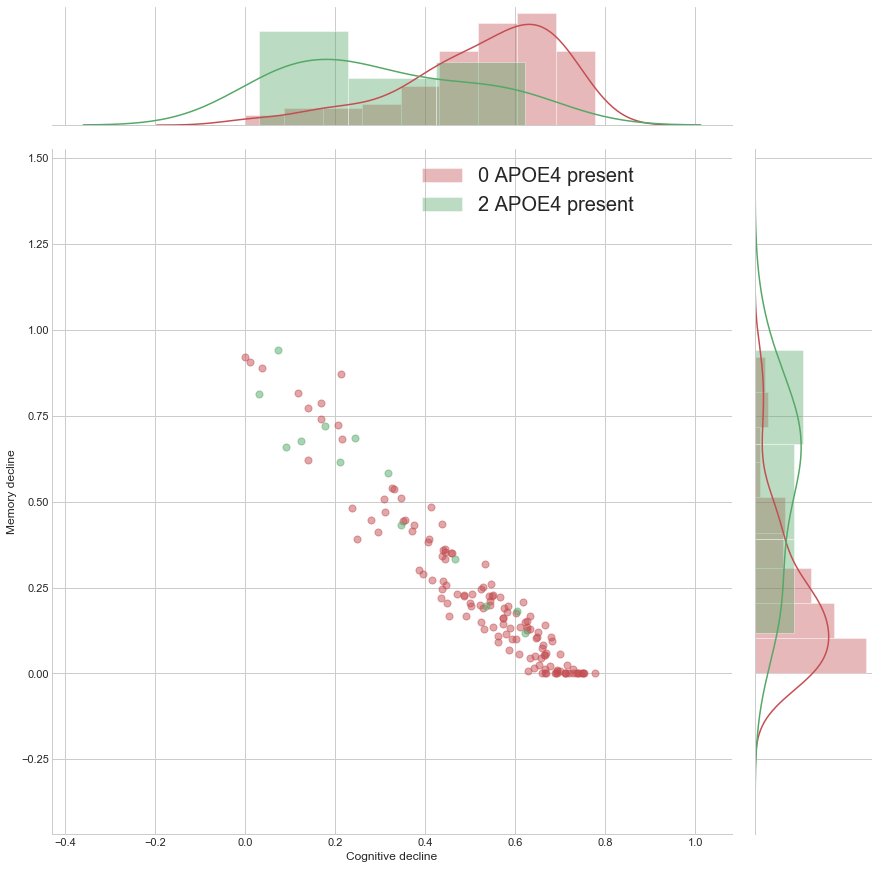

In [56]:
#Considering controls_nmf
x_red = list(controls_nmf[(controls_nmf['APOE4']==0).values]['NMF_2_1'].values) #Less than 75
y_red = list(controls_nmf[(controls_nmf['APOE4']==0).values]['NMF_2_2'].values)

x_blue = list(controls_nmf[(controls_nmf['APOE4']==1).values]['NMF_2_1'].values) #Greater than 75
y_blue = list(controls_nmf[(controls_nmf['APOE4']==1).values]['NMF_2_2'].values)

x_green = list(controls_nmf[(controls_nmf['APOE4']==2).values]['NMF_2_1'].values) #Greater than 75
y_green = list(controls_nmf[(controls_nmf['APOE4']==2).values]['NMF_2_2'].values)


plt.ion()
plt.show()
plt.pause(0.001)
a = 0.02
l = 10
zo = 0

p = sns.JointGrid(x = x_red, y = y_red , size=9)
p = p.plot_joint(plt.scatter, c="r", alpha = 0.5, s= 50)

p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.x = x_green
p.y = y_green
p.plot_joint(plt.scatter, c="g", alpha = 0.5, s= 50)
# plt.grid()
p.plot_marginals(sns.distplot, color='g', axlabel=[])
# plt.grid()
p.set_axis_labels(xlabel='Cognitive decline', ylabel='Memory decline', size = 12)
plt.legend(['0 APOE4 present', '2 APOE4 present'], loc = 'upper left',bbox_to_anchor=(-3.0, 1.0) ,prop={'size':20})
plt.gcf().set_size_inches(12.5, 12.5)
plt.savefig(address +'\\paper_fig\\' + 'apoe4_all_m48.png',dpi = 200)
plt.show()